In [1]:
# from google.colab import drive
# drive.mount('/content/drive')
# !pip install jittor
# !pip install pygmtools

In [2]:
import numpy as np
import pickle
import matplotlib.pyplot as plt


def load_cifar10_batch(file_path):
    with open(file_path, 'rb') as file:
        data_dict = pickle.load(file, encoding='bytes')
    images = data_dict[b'data']
    labels = data_dict[b'labels']
    return images, labels


# folder = "/content/drive/MyDrive"
# train_images1, train_labels1 = load_cifar10_batch(folder+'/cifar/data_batch_1')
# train_images2, train_labels2 = load_cifar10_batch(folder+'/cifar/data_batch_2')
# train_images3, train_labels3 = load_cifar10_batch(folder+'/cifar/data_batch_3')
# train_images4, train_labels4 = load_cifar10_batch(folder+'/cifar/data_batch_4')
# train_images5, train_labels5 = load_cifar10_batch(folder+'/cifar/data_batch_5')
# test_images, test_labels = load_cifar10_batch(folder+'/cifar/test_batch')

train_images1, train_labels1 = load_cifar10_batch('./cifar/data_batch_1')
train_images2, train_labels2 = load_cifar10_batch('./cifar/data_batch_2')
train_images3, train_labels3 = load_cifar10_batch('./cifar/data_batch_3')
train_images4, train_labels4 = load_cifar10_batch('./cifar/data_batch_4')
train_images5, train_labels5 = load_cifar10_batch('./cifar/data_batch_5')
test_images, test_labels = load_cifar10_batch('./cifar/test_batch')

train_images1 = train_images1.reshape((10000, 3, 32, 32))
train_images2 = train_images2.reshape((10000, 3, 32, 32))
train_images3 = train_images3.reshape((10000, 3, 32, 32))
train_images4 = train_images4.reshape((10000, 3, 32, 32))
train_images5 = train_images5.reshape((10000, 3, 32, 32))
test_images = test_images.reshape((10000, 3, 32, 32))

train_images = np.concatenate((train_images1, train_images2, train_images3,
                               train_images4, train_images5),
                              axis=0)
# print(train_images.shape)   # (50000, 3, 32, 32)


def segment(image, N=2):
    '''
    Args:
        image: ndarray with shape (batch_size*3*32*32)
        N: to segment the image to N*N blocks
    Return:
        blocks_shuffled: batch_size * (N*N) * 3 * (32//N) * (32//N)
        labels: batch_size * (N*N) * (N*N)
    '''
    assert 32 % N == 0, "The target size is illegal."

    batch_size, channels, height, width = image.shape
    assert channels == 3, "Number of channels is not 3."
    assert height == 32, "Height is not 32."
    assert width == 32, "Width is not 32."

    block_height = 32 // N
    block_width = 32 // N
    blocks_sorted = image.reshape(batch_size, channels, N, block_height, N,
                                  block_width)

    blocks_sorted = blocks_sorted.transpose(
        0, 2, 4, 1, 3, 5)  # batch_size * N * N * 3 * (32//N) * (32//N)

    blocks_sorted = blocks_sorted.reshape(batch_size, N * N, 3, 32 // N,
                                          32 // N)

    blocks_shuffled = np.zeros((batch_size, N * N, 3, 32 // N, 32 // N),
                               dtype=np.uint8)
    labels = np.zeros((batch_size, N * N, N * N), dtype=int)
    for img_index in range(batch_size):
        shuffle_indices = np.random.permutation(N * N)
        blocks_shuffled[img_index] = blocks_sorted[img_index, shuffle_indices]
        for i, j in enumerate(shuffle_indices):
            labels[img_index, i, j] = 1

    # img_to_show = 101
    # # print(labels[img_to_show])
    # i = 0
    # for pieces in range(N*N):
    #     plt.subplot(N, N, i+1)
    #     plt.imshow(blocks_shuffled[img_to_show, pieces, :, :, :].transpose(1, 2, 0))
    #     plt.axis('off')
    #     i += 1
    # plt.show()

    return blocks_shuffled, labels


# segment(train_images, 4)
train_blocks, train_p = segment(train_images, 2)  # 50000 * (N*N) * 3 * (32//N) * (32//N); 50000 * (N*N) * (N*N)
test_blocks, test_p = segment(test_images, 2)


In [3]:
import jittor as jt
from jittor.dataset import VarDataset, DataLoader

jt.flags.use_cuda = 1

batch_size = 128

train_blocks_var = jt.array(train_blocks)
train_p_var = jt.array(train_p)
train_dataset = VarDataset(train_blocks_var, train_p_var)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_blocks_var = jt.array(test_blocks)
test_p_var = jt.array(test_p)
test_dataset = VarDataset(test_blocks_var, test_p_var)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [10]:
import jittor as jt
from jittor import nn, Module
import pygmtools
# import cvxpy as cp
pygmtools.BACKEND = 'jittor'

conv1_output = 64

class Model(Module):
    # The image blocks are 16 * 16
    # Input: batch_size * 4 * 3 * 16 * 16
    def __init__(self, sinkhorn_flag=False, dropout_p=0.5):
        super(Model, self).__init__()
        self.sinkhorn = sinkhorn_flag

        self.conv1 = nn.Conv(3, conv1_output, 3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm(conv1_output)
        self.relu = nn.Relu()

        # self.conv2 = nn.Conv(conv1_output, conv1_output * 2, 3, stride=1, padding=1)
        self.conv2 = nn.Conv(conv1_output, conv1_output * 4, 3, stride=1, padding=1)

        # self.bn2 = nn.BatchNorm(conv1_output * 2)
        self.bn2 = nn.BatchNorm(conv1_output * 4)


        self.pool = nn.Pool(2, 2)

        # self.fc1 = nn.Linear(conv1_output * 2 * 8 * 8, conv1_output * 16)
        self.fc1 = nn.Linear(conv1_output * 4 * 8 * 8, conv1_output * 16)

        self.dp1 = nn.Dropout(dropout_p)

        self.fc2 = nn.Linear(conv1_output * 16 * 4, conv1_output * 16 * 8)

        self.dp2 = nn.Dropout(dropout_p)
        self.fc3 = nn.Linear(conv1_output * 16 * 8, 16)
        
    def execute(self, input):
        # assert input.shape[1] == 4, "Not 4 blocks each original image."
        temp = []
        input = input.float()
        for i in range(4):
            x = input[:, i, :, :, :]
            x = self.conv1(x)
            x = self.bn1(x)
            x = self.relu(x)

            x = self.conv2(x)
            x = self.bn2(x)
            x = self.relu(x)
            # print("conv finished")
            x = self.pool(x)
            x = jt.reshape(x, [x.shape[0], -1])     # batch_size * (conv1_output*2*8*8)

            x = self.fc1(x)                         # batch_size * (conv1_output*16)
            temp.append(x)
        merged = jt.cat(temp, dim=1)                # batch_size * (conv1_output*16*4)
        
        merged = self.relu(merged)
        merged = self.dp1(merged)

        merged = self.fc2(merged)
        merged = self.relu(merged)
        merged = self.dp2(merged)
        merged = self.fc3(merged)
       
        # d1, d2 = merged.shape
        # assert d1 == input.shape[0] and d2 == 16, f"Shape error in the network: [{d1},{d2}]"
    
        output = merged.reshape(input.shape[0], 4, 4)
        
        if self.sinkhorn == True:
            output = pygmtools.sinkhorn(output)     # batch_size * 4 * 4
        
        return output


# sinkhorn_flag = False
sinkhorn_flag = False
dropout = 0
epochs = 30

model = Model(sinkhorn_flag=sinkhorn_flag, dropout_p=dropout)
loss_function = nn.MSELoss()

learning_rate = 0.05
momentum = 0.9
weight_decay = 1e-5
optimizer = nn.SGD(model.parameters(), learning_rate, weight_decay=weight_decay)  #, momentum, weight_decay)


def train(model, train_loader, loss_function, optimizer, epoch):
    model.train()
    train_loss = []

    for batch_index, (inputs, targets) in enumerate(train_loader):
        outputs = model(inputs)
        targets = targets.float()
        # print("outputs.shape:",outputs.shape)
        # print(targets.shape)
        loss = loss_function(outputs, targets)
        # print("type of loss ", type(loss))
        # print(loss.shape)
        optimizer.step(loss)
        train_loss.append(loss)

        if batch_index % 100 == 0:
            print(f"Train epoch {epoch+1}, batch {batch_index}\tLoss: ", "%.5f" % loss)
    return train_loss

def test(model, test_loader, epoch):
    model.eval()
    total_correct = 0
    total_samples = 0
    for batch_index, (inputs, targets) in enumerate(test_loader):
        outputs = model(inputs)

        compare = (outputs.argmax(dim=2)[0] == targets.argmax(dim=2)[0])
        # print("compare.shape:",compare.shape)
        # assert compare.shape == (batch_size, 4), "Comparison shape error."
        correct = compare.sum().item()

        total_correct += correct
        total_samples += batch_size * 4

    test_acc = total_correct / total_samples
    print(f'Epoch {epoch+1}\tTest acc is {test_acc}\n')
    return test_acc


In [11]:
train_loss = []
test_acc = []

for epoch in range(epochs):
    loss = train(model, train_loader, loss_function, optimizer, epoch)
    train_loss += loss
    acc = test(model, test_loader, epoch)
    test_acc.append(acc)


Train epoch 1, batch 0	Loss:  0.26317
Train epoch 1, batch 100	Loss:  0.16503
Train epoch 1, batch 200	Loss:  0.13892
Train epoch 1, batch 300	Loss:  0.11504
Epoch 1	Test acc is 0.7235215585443038

Train epoch 2, batch 0	Loss:  0.11033
Train epoch 2, batch 100	Loss:  0.10490
Train epoch 2, batch 200	Loss:  0.10064
Train epoch 2, batch 300	Loss:  0.09994
Epoch 2	Test acc is 0.7642652294303798

Train epoch 3, batch 0	Loss:  0.10427
Train epoch 3, batch 100	Loss:  0.09072
Train epoch 3, batch 200	Loss:  0.09335
Train epoch 3, batch 300	Loss:  0.08571
Epoch 3	Test acc is 0.7843898338607594

Train epoch 4, batch 0	Loss:  0.07784
Train epoch 4, batch 100	Loss:  0.08992
Train epoch 4, batch 200	Loss:  0.07698
Train epoch 4, batch 300	Loss:  0.08716
Epoch 4	Test acc is 0.7970975079113924

Train epoch 5, batch 0	Loss:  0.08092
Train epoch 5, batch 100	Loss:  0.07550
Train epoch 5, batch 200	Loss:  0.09020
Train epoch 5, batch 300	Loss:  0.07829
Epoch 5	Test acc is 0.8110907832278481

Train epoc

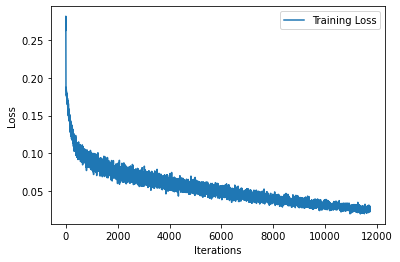

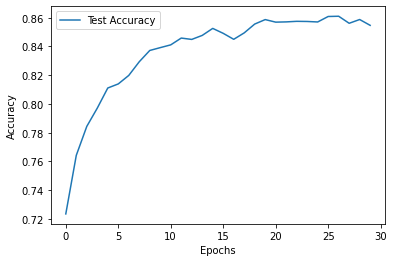

In [12]:
plt.plot(train_loss, label="Training Loss")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.legend()
if sinkhorn_flag:
    plt.savefig(
        f"figures/sh_epoch{epochs}_lr{learning_rate}_dp{dropout}_wd{weight_decay}_batch{batch_size}_{conv1_output}_loss.jpg",
        dpi=800)
else:
    plt.savefig(
        f"figures/epoch{epochs}_lr{learning_rate}_dp{dropout}_wd{weight_decay}_batch{batch_size}_{conv1_output}_loss.jpg",
        dpi=800)
plt.show()

plt.plot(test_acc, label="Test Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
if sinkhorn_flag:
    plt.savefig(
        f"figures/sh_epoch{epochs}_lr{learning_rate}_dp{dropout}_wd{weight_decay}_batch{batch_size}_{conv1_output}_acc.jpg",
        dpi=800)
else:
    plt.savefig(
        f"figures/epoch{epochs}_lr{learning_rate}_dp{dropout}_wd{weight_decay}_batch{batch_size}_{conv1_output}_acc.jpg",
        dpi=800)
plt.show()